# UNet on MNIST dataset

Unet is one of the fundamentals which bought revolution in the field of Image Generative AI. Unet tries to learn patterns in an image and based on that give output. Here I train using MNIST dataset from digits 1 to 10 and I test it against EMNIST Dataset which also includes alphabets in lower and upper case.

In [1]:
import time
from IPython import display

import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
from torch.utils import data
import matplotlib.pyplot as plt

## Actual Model
I wrote this model from scratch using the paper (U-Net: Convolutional Networks for Biomedical Image Segmentation).
https://arxiv.org/abs/1505.04597

This is based on my understanding of the model.

In [2]:
class UNetModel(nn.Module):

    def __init__(self,input_channels,output_channels=3):
        super().__init__()
        self.layer1 = self.defineFirstLayer(input_channels=input_channels)
        self.layer2 = self.defineSecondLayer()
        self.layer3 = self.defineThirdLayer()
        self.layer4 = self.defineFourthLayer()
        self.layer5 = self.defineFifthLayer()
        self.upCov1 = nn.ConvTranspose2d(1024,512,kernel_size=2,stride=2)
        self.layer6 = self.defineSixthLayer()
        self.upCov2 = nn.ConvTranspose2d(512,256,kernel_size=2,stride=2)
        self.layer7 = self.defineSeventhLayer()
        self.upCov3 = nn.ConvTranspose2d(256,128,kernel_size=2,stride=2)
        self.layer8 = self.defineEighthLayer()
        self.upCov4 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.layer9 = self.defineNinthLayer(output_channels)
    
    def defineFirstLayer(self,input_channels):
        return nn.Sequential(
            nn.Conv2d(input_channels,64,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3),
            nn.ReLU()
        )
    
    def defineSecondLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64,128,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3),
            nn.ReLU()
        )
    
    def defineThirdLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(128,256,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3),
            nn.ReLU()
        )
    
    def defineFourthLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(256,512,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3),
            nn.ReLU()
        )
    
    def defineFifthLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(512,1024,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(1024,1024,kernel_size=3),
            nn.ReLU()
        )

    def defineSixthLayer(self):
        return nn.Sequential(
            nn.Conv2d(1024,512,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(512,512,kernel_size=3),
            nn.ReLU()
        )
    
    
    def defineSeventhLayer(self):
        return nn.Sequential(
            nn.Conv2d(512,256,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3),
            nn.ReLU()
        )
    
    def defineEighthLayer(self):
        return nn.Sequential(
            nn.Conv2d(256,128,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3),
            nn.ReLU()
        )
    
    def defineNinthLayer(self,output_channels):
        return nn.Sequential(
            nn.Conv2d(128,64,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64,output_channels,kernel_size=1)
        )
    
    def crop_and_cat(self,cropTensor,catTensor,crop_by=4):
        cropTensor = cropTensor[:,:,crop_by:-crop_by,crop_by:-crop_by]  
        return torch.cat((cropTensor, catTensor),dim=1)
    
    def forward(self,X):
        X1 = self.layer1(X)
        X2 = self.layer2(X1)
        X3 = self.layer3(X2)
        X4 = self.layer4(X3)
        X5 = self.layer5(X4)
        X5_with_upscale = self.crop_and_cat(X4,self.upCov1(X5),crop_by=4)
        X6 = self.layer6(X5_with_upscale)  
        X6_with_upscale = self.crop_and_cat(X3,self.upCov2(X6),crop_by=16)
        X7 = self.layer7(X6_with_upscale)  
        X7_with_upscale = self.crop_and_cat(X2,self.upCov3(X7),crop_by=40)
        X8 = self.layer8(X7_with_upscale)  
        X8_with_upscale = self.crop_and_cat(X1,self.upCov4(X8),crop_by=88)
        X9 = self.layer9(X8_with_upscale)  
        return X9

model = UNetModel(input_channels=1,output_channels=1)
X = torch.rand(size=(1, 1, 572, 572), dtype=torch.float32)
model(X).shape

torch.Size([1, 1, 388, 388])

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((572,572))
    ]
)
training_data = torchvision.datasets.MNIST(root="../data/MINST", download=True, train=True, transform=transform)
validation_data = torchvision.datasets.MNIST(root="../data/MINST", download=True, train=False, transform=transform)


train_iter = torch.utils.data.DataLoader(training_data, batch_size=100, shuffle=True)
batch_size = len(train_iter)

# Training cycle

I am not showing the plot here since the RAM of the machine exceeds while training the model. I have tried to save and load the model to train it for longer cycles. Not sure about the epochs as trained on my personal laptop. Not on GPUs / TPUs. For the same reasons there are no test iterations as well.

I am using simple prints to display the loss function.

In [4]:
def train(net, train_iter, num_epochs, lr):
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)

  net.apply(init_weights)
  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  loss = nn.MSELoss(reduction="mean")
  x_resize = torchvision.transforms.Resize((388,388))
  num_batches = len(train_iter)
  for epoch in range(num_epochs):
    net.train()
    for i, (X,_) in enumerate(train_iter):
      optimizer.zero_grad()
      y_hat = net(X)
      y = x_resize(X)
      l = loss(y_hat,y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        print(epoch + (i + 1) / num_batches, l)

In [ ]:
lr, num_epochs = 0.001, 2
train(model, train_iter, num_epochs, lr)
torch.save(model, './unet_parameters_MNIST_mse.pt')

torch.save(model, './unet_parameters_MNIST_mse.pt')

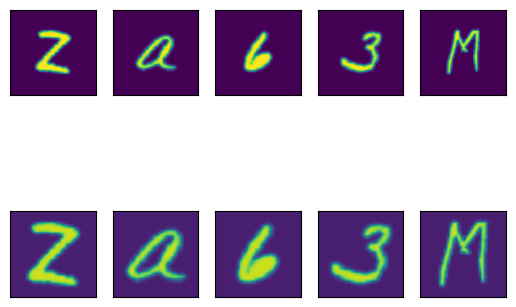

In [25]:
import random
model = torch.load('./unet_parameters_MNIST_mse.pt')
model.eval()
transform = transforms.Compose(
    [
        lambda img: torchvision.transforms.functional.rotate(img, -90),
        transforms.RandomHorizontalFlip(p=1),
        transforms.ToTensor(),
        transforms.Pad(10),
        transforms.Resize((572,572))
    ]
)

emnist = torchvision.datasets.EMNIST(root="../data/EMINST", split="byclass", download=True, transform=transform)
i=0
model.eval()
for image,y in emnist:
    x = torch.unsqueeze(image,dim=0)
    # print(x.shape)
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.permute(1,2,0))
    with torch.no_grad():
        result = model(x)[0]
        plt.subplot(2, 5, i+6)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(result.permute(1,2,0))
    i+=1
    if i>=5:
        break
plt.show()

## Mini-Unet

I tried to change the parameters for small sizes and train it. It worked to a certain extend, showing the details.

In [ ]:
class UNetModel(nn.Module):

    def __init__(self,input_channels=3,output_channels=3):
        super().__init__()
        self.layer1 = self.defineFirstLayer(input_channels)
        self.layer2 = self.defineSecondLayer()
        self.layer3 = self.defineThirdLayer()
        self.layer4 = self.defineFourthLayer()
        self.layer5 = self.defineFifthLayer()
        self.upCov1 = nn.ConvTranspose2d(128,64,kernel_size=2,stride=2)
        self.layer6 = self.defineSixthLayer()
        self.upCov2 = nn.ConvTranspose2d(64,32,kernel_size=2,stride=2)
        self.layer7 = self.defineSeventhLayer()
        self.upCov3 = nn.ConvTranspose2d(32,16,kernel_size=2,stride=2)
        self.layer8 = self.defineEighthLayer()
        self.upCov4 = nn.ConvTranspose2d(16,8,kernel_size=2,stride=2)
        self.layer9 = self.defineNinthLayer(output_channels)
    
    def defineFirstLayer(self,input_channels):
        return nn.Sequential(
            nn.Conv2d(input_channels,8,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(8,8,kernel_size=3),
            nn.ReLU()
        )
    
    def defineSecondLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(8,16,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16,16,kernel_size=3),
            nn.ReLU()
        )
    
    def defineThirdLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(16,32,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32,32,kernel_size=3),
            nn.ReLU()
        )
    
    def defineFourthLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(32,64,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3),
            nn.ReLU()
        )
    
    def defineFifthLayer(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(64,128,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3),
            nn.ReLU()
        )

    def defineSixthLayer(self):
        return nn.Sequential(
            nn.Conv2d(128,64,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(64,64,kernel_size=3),
            nn.ReLU()
        )
    
    
    def defineSeventhLayer(self):
        return nn.Sequential(
            nn.Conv2d(64,32,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32,32,kernel_size=3),
            nn.ReLU()
        )
    
    def defineEighthLayer(self):
        return nn.Sequential(
            nn.Conv2d(32,16,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16,16,kernel_size=3),
            nn.ReLU()
        )
    
    def defineNinthLayer(self,output_channels):
        return nn.Sequential(
            nn.Conv2d(16,8,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(8,8,kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(8,output_channels,kernel_size=1)
        )
    
    def crop_and_cat(self,cropTensor,catTensor,crop_by=(4,4)):
        cropTensor = self.crop(cropTensor,crop_by)
        # print(cropTensor.shape)
        # print(catTensor.shape)
        return torch.cat((cropTensor, catTensor),dim=1)


    def crop(self,cropTensor,crop_by):
        # print(crop_by)
        match crop_by:
            case (16,17):
                return cropTensor[:,:,crop_by[0]:-crop_by[0]-1,crop_by[1]:-crop_by[1]+1] 
            case _:
                return cropTensor[:,:,crop_by[0]:-crop_by[0],crop_by[1]:-crop_by[1]]
    
    def forward(self,X):
        X1 = self.layer1(X)
        X2 = self.layer2(X1)
        X3 = self.layer3(X2)
        X4 = self.layer4(X3)
        X5 = self.layer5(X4)
        X5_with_upscale = self.crop_and_cat(X4,self.upCov1(X5),crop_by=(4,4))
        X6 = self.layer6(X5_with_upscale)  
        X6_with_upscale = self.crop_and_cat(X3,self.upCov2(X6),crop_by=(16,17))
        X7 = self.layer7(X6_with_upscale)  
        X7_with_upscale = self.crop_and_cat(X2,self.upCov3(X7),crop_by=(41,41))
        X8 = self.layer8(X7_with_upscale)  
        X8_with_upscale = self.crop_and_cat(X1,self.upCov4(X8),crop_by=(90,90))
        X9 = self.layer9(X8_with_upscale)  
        return X9

model = UNetModel(input_channels=1,output_channels=1)
X = torch.rand(size=(1, 1, 256, 256), dtype=torch.float32)
model(X).shape

## Data
Data is changed from size (572, 572) to (256,256) decreasing the no. pixels to half of the actual. I have used pad while transforming to learn the content information more than the other values as unet trains on central-pixel information as we crop and concat the central information.

In [ ]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Pad(50),
        transforms.Resize((256,256))
    ]
)
training_data = torchvision.datasets.MNIST(root="../data/MINST", download=True, train=True, transform=transform)
validation_data = torchvision.datasets.MNIST(root="../data/MINST", download=True, train=False, transform=transform)


train_iter = torch.utils.data.DataLoader(training_data, batch_size=500, shuffle=True)

In [ ]:
def train(net, train_iter, num_epochs, lr):
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)

  net.apply(init_weights)
  optimizer = torch.optim.Adam(net.parameters(), lr=lr,weight_decay=0.0001)
  loss = nn.MSELoss(reduction='mean')
  x_resize = torchvision.transforms.Resize((68,68))
  for epoch in range(num_epochs):
    net.train()
    for i, (X,_) in enumerate(train_iter):
      optimizer.zero_grad()
      y_hat = net(X)
      y = x_resize(X)
      l = loss.forward(y_hat,y)
      optimizer.step()
      with torch.no_grad():
        print(f'epoch : {epoch}, batch per epoch : {i}, Y : {l}')

In [ ]:
lr, num_epochs = 0.007, 2
# file_name = './unet_small_parameters_MNIST_mse.pt'
train(model, train_iter, num_epochs, lr)

## Analysis

As you can see above I trained using 1-10 but I get outputs alphabets as well. This means the model understands the changes of the base level in the image. There is not much of a training cycle using this analysis as MNIST has too less information to be learned so training cycles remain constant during the epochs. However if we take a proper RGB images for training we might need bigger machine and resource to train it up to the mark.